# Introdução

Minha adaptação está liberada somente para exploração, o compartilhamento só é permitido para utilizar com imagens das quais você tem o direito explícito para gerar um deep fake.

Automatizado por Guilherme Silveira, https://twitter.com/guilhermecaelum

Original de https://colab.research.google.com/github/AliaksandrSiarohin/first-order-model/blob/master/demo.ipynb "First Order Motion Model for Image Animation"

TODO 1: Add folder https://drive.google.com/drive/folders/1kZ1gCnpfU0BnpdU47pLM_TQ6RypDDqgw?usp=sharing  to your google drive.

In [47]:
# TODO 2

base_name = "mariosouto"

In [48]:
# TODO 3

# assumindo que o vídeo é 1920 x 1080
# o rosto da pessoa está na parte "de baixo" do vídeo

DIMENSION = 1080
MIN_X = 0
MIN_Y = 640

should_crop = True

## Setup de diretórios

**Git clone**

In [49]:
!git clone https://github.com/AliaksandrSiarohin/first-order-model

Cloning into 'first-order-model'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 71.46 MiB | 21.92 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [50]:
cd first-order-model

/content/first-order-model/first-order-model/first-order-model


**Mount your Google drive folder on Colab**

In [51]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Pequenas alterações no vídeo original

## Conferindo dimensões

In [52]:
movie_input = base_name
movie_original = f"/content/gdrive/My Drive/deepfake/{movie_input}.mp4"

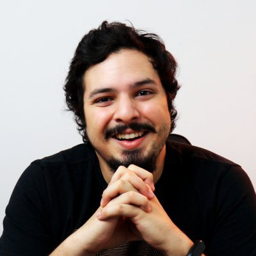

In [53]:
input = base_name
image_output = f"/content/gdrive/My Drive/deepfake/{input}-256.png"

from PIL import Image
im = Image.open(f"/content/gdrive/My Drive/deepfake/{input}.png")
width, height = im.size

ratio = width/height
if ratio > 1.05 or ratio < 0.95:
  raise Exception(f"Oh, a imagem que você pegou não é quadrada, vai zoar! {width} x {height}")

if width < 256:
  raise Exception(f"Oh, a imagem que você pegou é pequena, vai zoar! {width}")

im.thumbnail((256, 256))
im.save(image_output)
display(im)

In [54]:
import os
import shutil
from moviepy.editor import VideoFileClip

movie_source = "../movie_quadrado.mp4"

if should_crop:
  shutil.copyfile(movie_original, '../movie_original.mp4')
  !ffmpeg -y -hide_banner -loglevel warning -i ../movie_original.mp4 -filter:v 'crop={DIMENSION}:{DIMENSION}:{MIN_X}:{MIN_Y}' ../movie_quadrado.mp4
else:
  shutil.copyfile(movie_original, movie_source)


In [55]:
from moviepy.editor import ipython_display
ipython_display(movie_source, width=256)


## Gerando mp3 e alterando tamanhos

In [56]:
generated_audio = f"../generated_audio_{basename}.mp3"
!ffmpeg -y -hide_banner -loglevel warning -i ../movie_original.mp4 -vn -ar 44100 -ac 2 -ab 192k -f mp3 $generated_audio


In [57]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

source_image = imageio.imread(image_output)
driving_video = imageio.mimread(movie_source, memtest=False)


#Resize image and video to 256x256

source_image = resize(source_image, (256, 256))[..., :3]
driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

def display_side_by_side(source, driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani
    

HTML(display_side_by_side(source_image, driving_video).to_html5_video())

# O deepfake

In [58]:
# se a célula a seguir não funcionar, descomente a linha a seguir
# por exemplo, se você usa o google colab pro, você talvez
# tenha que definir qual device de GPU será utilizado, por isso ;)

CUDA_VISIBLE_DEVICES=0

In [59]:
# Outro possível problema
# Caso você não tenha o GPU ativado por padrão, você pode ir no menu Runtime > Change runtime type > GPU

# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
#   print('and then re-execute this cell.')
# else:
#   print(gpu_info)

In [60]:
from demo import load_checkpoints
generator, kp_detector = load_checkpoints(config_path='config/vox-256.yaml', 
                            checkpoint_path='/content/gdrive/My Drive/first-order-motion-model/vox-cpk.pth.tar')

## Animando

In [ ]:
from demo import make_animation
from skimage import img_as_ubyte
from skimage.io import concatenate_images

predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True)

HTML(display_side_by_side(source_image, driving_video, predictions).to_html5_video())

100%|██████████| 433/433 [00:09<00:00, 45.79it/s]


In [ ]:
def frames_to_frame(f1, f2,f3):
  return np.concatenate((f1, np.array(f2), np.array(f3)),axis=1)

In [ ]:
imageio.mimsave('../generated.mp4', [img_as_ubyte(frames_to_frame(source_image,f2,f3)) for f2,f3 in zip(driving_video, predictions)])
HTML(display_side_by_side(source_image, driving_video, predictions).to_html5_video())

In [ ]:
from google.colab import files

# files.download('../generated.mp4') 
ipython_display("../generated.mp4")


## Definindo a velocidade

In [ ]:
from moviepy.editor import VideoFileClip
generated_duration = VideoFileClip("../generated.mp4").duration
original_duration = VideoFileClip("../movie_original.mp4").duration
multiple = generated_duration / original_duration
print( generated_duration, original_duration, multiple )

## O vídeo final

In [ ]:
setpts = f'setpts=PTS/{multiple}'
!ffmpeg -y -hide_banner -loglevel warning -i "../generated.mp4" -filter:v $setpts "../generated_speed_control.mp4"
print(f"Colocando o áudio")

final_name = f"../generated_final_{base_name}.mp4"
!ffmpeg -y -hide_banner -loglevel warning -i "../generated_speed_control.mp4" -i $generated_audio -c:v copy -c:a aac $final_name
files.download(final_name)

ipython_display(final_name)

## Demonstração de keypoint relativos

Estilo de cabelo etc serão copiados

In [ ]:
predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=False, adapt_movement_scale=True)
HTML(display_side_by_side(source_image, driving_video, predictions).to_html5_video())